# Событийная аналитика интернет-магазина

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Обзор-и-предобработка-данных" data-toc-modified-id="Обзор-и-предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Описание" data-toc-modified-id="Описание-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Описание</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Предобработка</a></span></li><li><span><a href="#Оценка-распределения" data-toc-modified-id="Оценка-распределения-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Оценка распределения</a></span></li></ul></li><li><span><a href="#Создание-воронки-событий" data-toc-modified-id="Создание-воронки-событий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание воронки событий</a></span><ul class="toc-item"><li><span><a href="#Распределение-событий-по-частоте" data-toc-modified-id="Распределение-событий-по-частоте-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Распределение событий по частоте</a></span></li><li><span><a href="#Изучение-конверсии" data-toc-modified-id="Изучение-конверсии-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Изучение конверсии</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Изучение-результатов-эксперимента" data-toc-modified-id="Изучение-результатов-эксперимента-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучение результатов эксперимента</a></span><ul class="toc-item"><li><span><a href="#Сравнение-показателей-конверсии-между-группами" data-toc-modified-id="Сравнение-показателей-конверсии-между-группами-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Сравнение показателей конверсии между группами</a></span></li><li><span><a href="#Оценка-статистической-значимости" data-toc-modified-id="Оценка-статистической-значимости-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Оценка статистической значимости</a></span><ul class="toc-item"><li><span><a href="#Событие-1---Посещение-главной-страницы" data-toc-modified-id="Событие-1---Посещение-главной-страницы-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Событие 1 - Посещение главной страницы</a></span></li><li><span><a href="#Событие-2---Посещение-страницы-товара" data-toc-modified-id="Событие-2---Посещение-страницы-товара-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Событие 2 - Посещение страницы товара</a></span></li><li><span><a href="#Событие-3---Добавление-товара-в-корзину" data-toc-modified-id="Событие-3---Добавление-товара-в-корзину-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Событие 3 - Добавление товара в корзину</a></span></li><li><span><a href="#Событие-4---Успешная-оплата-заказа" data-toc-modified-id="Событие-4---Успешная-оплата-заказа-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Событие 4 - Успешная оплата заказа</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Постановка задачи

Необходимо проанализировать поведение пользователей, составив воронку продаж.

Также по результатам данных A/A/B тестирования необходимо оценить, повлияло ли изменение интерфейса на увеличение количества заказов и конверсии.

## Обзор и предобработка данных

### Описание

Имеющиеся лог-файлы содержат информацию о действиях, совершенных пользователями, где: 

`EventName` — название события;  
`DeviceIDHash` — уникальный идентификатор пользователя;  
`EventTimestamp` — время события;  
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import stats as st
from datetime import datetime
from statsmodels.stats.weightstats import ztest as ztest

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Datasets/logs_exp.csv', sep='\t')

In [4]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Предобработка

Для удобства наименования столбцов заменяются, а также названия групп устанавливаются: `A1`, `A2`, `B`.

In [4]:
df.columns = ['event_type', 'user_id', 'timestamp', 'group']

In [5]:
df['group'] = df['group'].replace([246, 247, 248], ['A1', 'A2', 'B'])

Данные приводятся к необходимому формату, а также добавляются столбцы с датой для последующей обработки.

In [6]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = pd.to_datetime(df['timestamp'], unit='s').dt.date

In [7]:
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

In [8]:
df = df.drop(columns='timestamp')

In [9]:
df.head()

,event_type,user_id,group,datetime,date,month,day
0,MainScreenAppear,4575588528974610257,A1,2019-07-25 04:43:36,2019-07-25,7,25
1,MainScreenAppear,7416695313311560658,A1,2019-07-25 11:11:42,2019-07-25,7,25
2,PaymentScreenSuccessful,3518123091307005509,B,2019-07-25 11:28:47,2019-07-25,7,25
3,CartScreenAppear,3518123091307005509,B,2019-07-25 11:28:47,2019-07-25,7,25
4,PaymentScreenSuccessful,6217807653094995999,B,2019-07-25 11:48:42,2019-07-25,7,25


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_type  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   group       244126 non-null  object        
 3   datetime    244126 non-null  datetime64[ns]
 4   date        244126 non-null  object        
 5   month       244126 non-null  int64         
 6   day         244126 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.0+ MB


Данные записаны без пропусков.  
Также необходимо проверить наличие дубликатов и некорректных значений.

In [11]:
sum(df.duplicated())

413

In [12]:
df = df.drop_duplicates()

In [13]:
df['event_type'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [14]:
users_a1 = df.query('group == "A1"')
users_a2 = df.query('group == "A2"')
users_b = df.query('group == "B"')

In [15]:
users_a1_a2 = users_a1.merge(users_a2, on='user_id', how='inner')
users_a1_b = users_a1.merge(users_b, on='user_id', how='inner')
users_a2_b = users_a2.merge(users_b, on='user_id', how='inner')

users_a1_a2 = list(users_a1_a2["user_id"].unique())
users_a1_b = list(users_a1_b["user_id"].unique())
users_a2_b = list(users_a2_b["user_id"].unique())

In [16]:
print(users_a1_a2)
print(users_a1_b)
print(users_a2_b)

[]
[]
[]


Полные дубликаты удалены, неявные дубликаты не обнаружены.  
  
Пользователели распределены корреткно, пересечений между группами не обнаружено.

### Оценка распределения

Необходимо провести общий анализ распределения событий по группам, а также по датам проведения теста.

In [17]:
a1 = df.query('group == "A1"')
a2 = df.query('group == "A2"')
b = df.query('group == "B"')

print(f'''Событий в контрольной группе A1: {len(a1)}
Событий в контрольной группе A2: {len(a2)}
Разница между контрольными группами: {(len(a1) / len(a2))-1 :.2%}

Событий в группе B: {len(b)}''')

Событий в контрольной группе A1: 80181
Событий в контрольной группе A2: 77950
Разница между контрольными группами: 2.86%

Событий в группе B: 85582


In [18]:
events_total = len(df)
users_total = df["user_id"].nunique()
event_per_user = len(df) / df["user_id"].nunique()

print(f'''Всего событий: {events_total}
Уникальных пользователей: {users_total}
Событий на 1-го пользователя (в среднем): {event_per_user:.3}''')

Всего событий: 243713
Уникальных пользователей: 7551
Событий на 1-го пользователя (в среднем): 32.3


In [19]:
users_a1 = a1["user_id"].nunique()
users_a2 = a2["user_id"].nunique()
users_b = b["user_id"].nunique()

print(f'''Уникальных пользователей в группе A1: {users_a1}
Уникальных пользователей в группе A2: {users_a2}
Разница между контрольными группами: {(users_a2 / users_a1)-1 :.2%}

Уникальных пользователей в группе B: {users_b}
''')

Уникальных пользователей в группе A1: 2489
Уникальных пользователей в группе A2: 2520
Разница между контрольными группами: 1.25%

Уникальных пользователей в группе B: 2542



In [20]:
df['date'].describe()

count         243713
unique            14
top       2019-08-01
freq           36141
Name: date, dtype: object

In [21]:
df['date'].min()

datetime.date(2019, 7, 25)

In [22]:
df['date'].max()

datetime.date(2019, 8, 7)

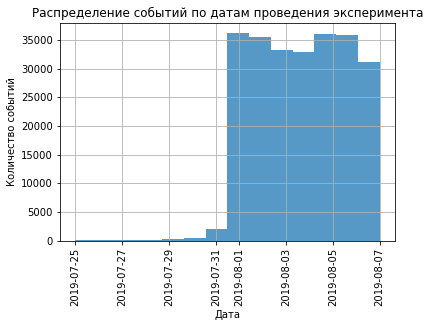

In [23]:
plt.title('Распределение событий по датам проведения эксперимента')
plt.xlabel('Дата')
plt.ylabel('Количество событий')

df['date'].hist(bins=14, xrot=90, alpha=0.75);

In [24]:
df.pivot_table(index='date', values='user_id', aggfunc='count')

,user_id
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


Данные получены за период с 25 июля по 7 августа, одназо до 31 августа включительно информации недостаточно.  
Эти данные необходимо исключить для корректности обработки.

In [25]:
df = df.query('month == 8')

In [26]:
df['date'].describe()

count         240887
unique             7
top       2019-08-01
freq           36141
Name: date, dtype: object

In [27]:
events_total_filtered = len(df)
users_total_filtered = df["user_id"].nunique()
event_per_user_filtered = len(df) / df["user_id"].nunique()

print(f'''Всего событий: {events_total_filtered} 
(Отфильтровано {(events_total - events_total_filtered) / events_total :.2%})

Уникальных пользователей: {users_total_filtered}
(Отфильтровано {(users_total - users_total_filtered) / users_total :.2%})

Событий на 1-го пользователя (в среднем): {event_per_user_filtered:.3}''')

Всего событий: 240887 
(Отфильтровано 1.16%)

Уникальных пользователей: 7534
(Отфильтровано 0.23%)

Событий на 1-го пользователя (в среднем): 32.0


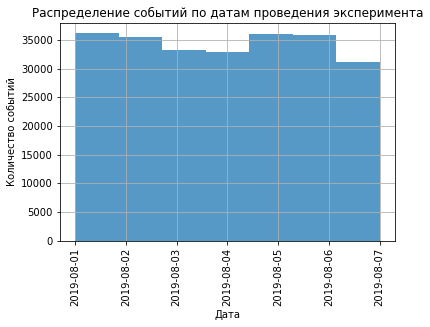

In [28]:
plt.title('Распределение событий по датам проведения эксперимента')
plt.xlabel('Дата')
plt.ylabel('Количество событий')

df['date'].hist(xrot = 90, bins=7, alpha=0.75);

In [29]:
a1_filtered = df.query('group == "A1"')
a2_filtered = df.query('group == "A2"')
b_filtered = df.query('group == "B"')

print(f'''Размер контрольной группы A1: {len(a1_filtered)}
(Отфильтровано {(len(a1) - len(a1_filtered)) / len(a1) :.2%})

Размер контрольной группы A2: {len(a2_filtered)}
(Отфильтровано {(len(a2) - len(a2_filtered)) / len(a2) :.2%})

Разница между контрольными группами: {(len(a1_filtered) / len(a2_filtered))-1 :.2%}

Размер группы B: {len(b_filtered)}
(Отфильтровано {(len(b) - len(b_filtered)) / len(b) :.2%})''')

Размер контрольной группы A1: 79302
(Отфильтровано 1.10%)

Размер контрольной группы A2: 77022
(Отфильтровано 1.19%)

Разница между контрольными группами: 2.96%

Размер группы B: 84563
(Отфильтровано 1.19%)


In [30]:
users_a1_filtered = a1_filtered["user_id"].nunique()
users_a2_filtered = a2_filtered["user_id"].nunique()
users_b_filtered = b_filtered["user_id"].nunique()

print(f'''Уникальных пользователей в группе A1: {users_a1_filtered}
Уникальных пользователей в группе A2: {users_a2_filtered}
Разница между контрольными группами: {(users_a2_filtered / users_a1_filtered)-1 :.2%}

Уникальных пользователей в группе B: {users_b_filtered}
''')

Уникальных пользователей в группе A1: 2484
Уникальных пользователей в группе A2: 2513
Разница между контрольными группами: 1.17%

Уникальных пользователей в группе B: 2537



Контрольные группы отличаются более чем на 1%, что может свидетельствовать о недостаточно точном распределении пользователей между группами.  
Это может повлиять на точность прогнозов при сравнении группы B с контрольными.

## Создание воронки событий

### Распределение событий по частоте

Следующим шагом является исследование типов событий, частота совершений их пользователями, а также составление "Маршрута" пользователя при совершении заказа.

In [31]:
pivot_event_type = df.pivot_table(index='event_type', 
                                  values='user_id', 
                                  aggfunc='count').sort_values(by='user_id', 
                                                               ascending=True)

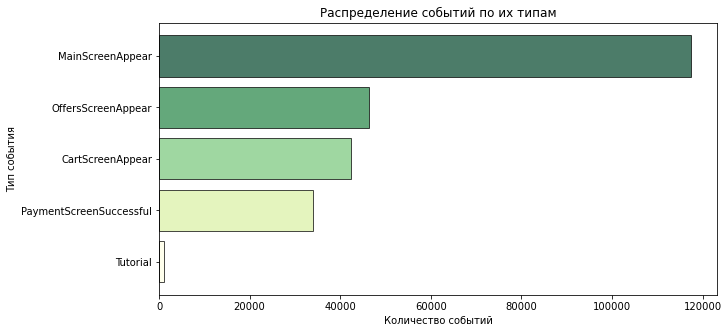

In [32]:
x = pivot_event_type.index
y = pivot_event_type['user_id']

plt.figure(figsize=(10,5))

plt.title('Распределение событий по их типам')
plt.xlabel('Количество событий')
plt.ylabel('Тип события')

colors = plt.cm.YlGn(np.linspace(0, 1, len(x)))

plt.barh(x, y, color=colors, edgecolor = "black", alpha=0.7)
plt.show()

Наиболее частым является событие `MainScreenAppear` (`Главная страница`)    

Далее следует `OffersScreenAppear` (`Страница товара`)    

Затем `CartScreenAppear` (`Корзина`)    

И наконец `PaymentScreenSuccessful` (`Подтверждение оплаты заказа`)   

Также имеется событие `Tutorial` (`Обучение`), однако оно не участвует в маршруте пользователя при оформлении заказа.

По имеющемуся гграфику можно приблизительно оценить частоту перехода пользователей с предыдущего шага на каждый последующий, однако стоит рассмотреть эти процессы подробнее:

### Изучение конверсии

In [33]:
pivot_event_type_users = df.pivot_table(index='event_type', 
                                  values='user_id', 
                                  aggfunc='nunique').sort_values(by='user_id', 
                                                               ascending=True)
pivot_event_type_users.columns = ['step_users']

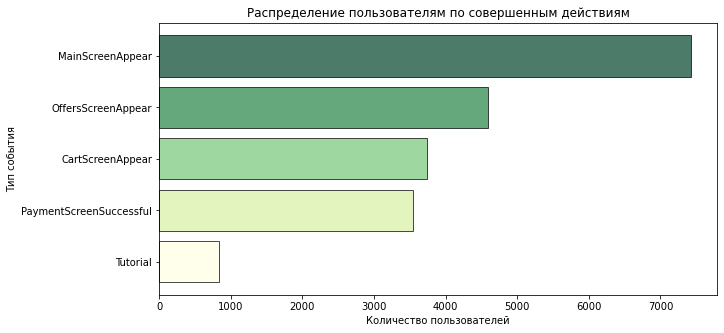

In [34]:
x = pivot_event_type_users.index
y = pivot_event_type_users['step_users']

plt.figure(figsize=(10,5))

plt.title('Распределение пользователям по совершенным действиям')
plt.xlabel('Количество пользователей')
plt.ylabel('Тип события')

colors = plt.cm.YlGn(np.linspace(0, 1, len(x)))

plt.barh(x, y, color=colors, edgecolor = "black", alpha=0.7)
plt.show()

Заметно, что наименьшая конверсия наблюдается между первым и вторым шагом, то есть при выборе товара на главной странице.

In [35]:
pivot_event_type_users = pivot_event_type_users.drop('Tutorial').sort_values(by='step_users', ascending=False)

In [36]:
pivot_event_type_users.insert(0, 'step_number', range(len(pivot_event_type_users.index)))

In [37]:
pivot_event_type_users['prev_step_users'] = pivot_event_type_users['step_users'].shift(1)
pivot_event_type_users['prev_step_users'][0] = pivot_event_type_users['step_users'][0]
pivot_event_type_users['prev_step_users'] = pivot_event_type_users['prev_step_users'].astype(int)

In [38]:
pivot_event_type_users['step_users_percent'] = round(pivot_event_type_users['step_users'] \
                                                / pivot_event_type_users['prev_step_users'] *100 , 2)

In [39]:
pivot_event_type_users['total_users_percent'] = round(pivot_event_type_users['step_users'] \
                                                / pivot_event_type_users['step_users'][0] *100 , 2)

In [40]:
pivot_event_type_users

,step_number,step_users,prev_step_users,step_users_percent,total_users_percent
event_type,,,,,
MainScreenAppear,0,7419,7419,100.00,100.00
OffersScreenAppear,1,4593,7419,61.91,61.91
CartScreenAppear,2,3734,4593,81.30,50.33
PaymentScreenSuccessful,3,3539,3734,94.78,47.70


В таблице представлено количество уникальных пользователей, совершивших каждое из действий, а также конверсия каждого "шага" и общая конверсия.

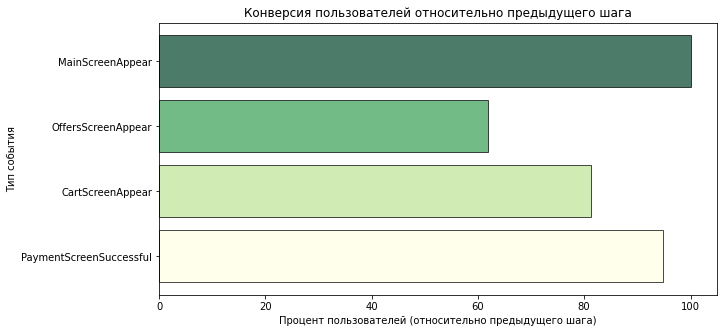

In [41]:
pivot_event_type_users = pivot_event_type_users.sort_values(by='step_users', ascending=True)

x = pivot_event_type_users.index
y = pivot_event_type_users['step_users_percent']

plt.figure(figsize=(10,5))

plt.title('Конверсия пользователей относительно предыдущего шага')
plt.xlabel('Процент пользователей (относительно предыдущего шага)')
plt.ylabel('Тип события')

colors = plt.cm.YlGn(np.linspace(0, 1, len(x)))

plt.barh(x, y, color=colors, edgecolor = "black", alpha=0.7)
plt.show()

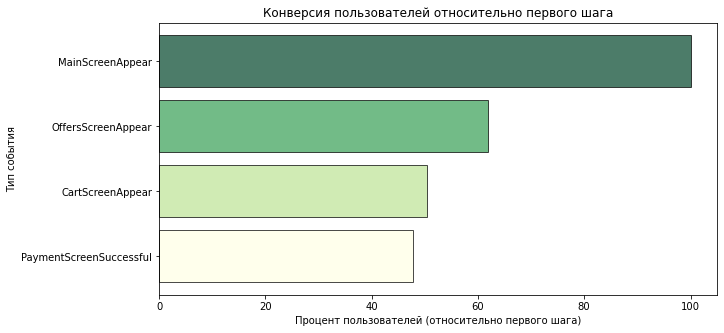

In [42]:
pivot_event_type_users = pivot_event_type_users.sort_values(by='step_users', ascending=True)

x = pivot_event_type_users.index
y = pivot_event_type_users['total_users_percent']

plt.figure(figsize=(10,5))

plt.title('Конверсия пользователей относительно первого шага')
plt.xlabel('Процент пользователей (относительно первого шага)')
plt.ylabel('Тип события')

colors = plt.cm.YlGn(np.linspace(0, 1, len(x)))

plt.barh(x, y, color=colors, edgecolor = "black", alpha=0.7)
plt.show()

### Вывод

Маршрут пользователя при оформлении заказа состоит из 4 шагов:  
`Главная страница` - `Страница товара` - `Корзина` - `Подтверждение оплаты заказа`.   
  
Общая конверсия пользователей при посещении сайта составляет около 50%.  
Худший показатель имеет этап перехода с главной страницы к странице товара (около 60%).  
Далее более 80% пользоватей, выбравших товар завершают оформление и оплату заказа.

## Изучение результатов эксперимента

### Сравнение показателей конверсии между группами

In [43]:
def whirpool (data, group):

    pivot_event_type_users_query = data.query('group == @group').pivot_table(index='event_type', 
                                  values='user_id', 
                                  aggfunc='nunique').sort_values(by='user_id', 
                                                               ascending=True)
    pivot_event_type_users_query.columns = ['step_users']

    pivot_event_type_users_query = pivot_event_type_users_query.drop('Tutorial')

    pivot_event_type_users_query = pivot_event_type_users_query.sort_values(by='step_users', ascending=False)

    pivot_event_type_users_query.insert(0, 'step_number', range(len(pivot_event_type_users_query.index)))

    pivot_event_type_users_query['prev_step_users'] = pivot_event_type_users_query['step_users'].shift(1)
    pivot_event_type_users_query['prev_step_users'][0] = pivot_event_type_users_query['step_users'][0]
    pivot_event_type_users_query['prev_step_users'] = pivot_event_type_users_query['prev_step_users'].astype(int)

    pivot_event_type_users_query['step_users_percent'] = round(pivot_event_type_users_query['step_users'] \
                                                / pivot_event_type_users_query['prev_step_users'] *100 , 2)

    pivot_event_type_users_query['total_users_percent'] = round(pivot_event_type_users_query['step_users'] \
                                                / pivot_event_type_users_query['step_users'][0] *100 , 2)

    return pivot_event_type_users_query

С помошью вышеописанной функции создаем сводные таблицы с данными о пользователях и конверсии каждого шага, а также общей конверсии.

In [44]:
pivot_A1 = whirpool (df, 'A1')

pivot_A1

,step_number,step_users,prev_step_users,step_users_percent,total_users_percent
event_type,,,,,
MainScreenAppear,0,2450,2450,100.00,100.00
OffersScreenAppear,1,1542,2450,62.94,62.94
CartScreenAppear,2,1266,1542,82.10,51.67
PaymentScreenSuccessful,3,1200,1266,94.79,48.98


In [45]:
pivot_A2 = whirpool (df, 'A2')

pivot_A2

,step_number,step_users,prev_step_users,step_users_percent,total_users_percent
event_type,,,,,
MainScreenAppear,0,2476,2476,100.00,100.00
OffersScreenAppear,1,1520,2476,61.39,61.39
CartScreenAppear,2,1238,1520,81.45,50.00
PaymentScreenSuccessful,3,1158,1238,93.54,46.77


In [46]:
pivot_B = whirpool (df, 'B')

pivot_B

,step_number,step_users,prev_step_users,step_users_percent,total_users_percent
event_type,,,,,
MainScreenAppear,0,2493,2493,100.00,100.00
OffersScreenAppear,1,1531,2493,61.41,61.41
CartScreenAppear,2,1230,1531,80.34,49.34
PaymentScreenSuccessful,3,1181,1230,96.02,47.37


Далее совмещаем полученные данные графически.

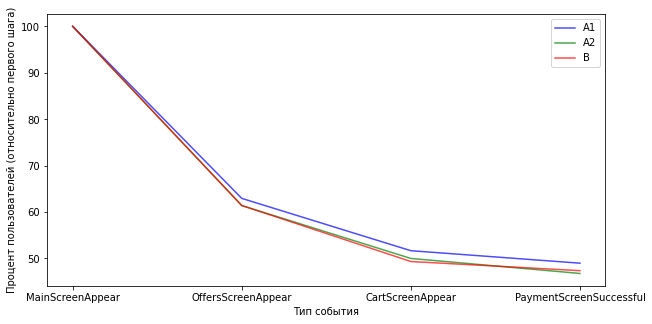

In [47]:
plt.figure(figsize=(10,5))

plt.ylabel('Процент пользователей (относительно первого шага)')
plt.xlabel('Тип события')

x = pivot_A1.index
y = pivot_A1['total_users_percent']
colors = 'b'

plt.plot(x, y, color=colors, alpha=0.7, label = 'A1')

x = pivot_A2.index
y = pivot_A2['total_users_percent']
colors = 'g'
plt.plot(x, y, color=colors, alpha=0.7, label = 'A2')

x = pivot_B.index
y = pivot_B['total_users_percent']
colors = 'r'
plt.plot(x, y, color=colors, alpha=0.7, label = 'B')

plt.legend()

plt.show()

Как видно из графика, различия между группами есть, но они минимальны.

Необходимо оценить, являются ли эти различия статистически значимыми.

### Оценка статистической значимости

Для оценки различий между выборками необходимо посчитать количество пользователей в каждой группе на протяжении эксперимента  
  
Далее следует выяснить, какая доля пользователей каждой группы соверщила значимое действие (в данном случае - перешла на страницу товара)  
  
Затем проверить, удовлетворяют ли полученные данные гипотезам:  
**H0** - Контрольные группы A1 и A2 одинаковы  
**H1** - Контрольные группы отличаются (имеются ошибки в распределении трафика)

**H0** - Конверсия пользователей группы B не отличается от контрольных групп  
**H1** - Конверсия группы B отличается

In [48]:
tmp = df.query('group == "A1"')
tmp = tmp.query('event_type == "MainScreenAppear"')

visitors_A1 = tmp.pivot_table(index='date', values='user_id', aggfunc='nunique')
visitors_A1.columns = ['visitors_A1']

visitors_A1['visitors_A1_cumm'] = visitors_A1['visitors_A1'].cumsum()

In [49]:
tmp = df.query('group == "A2"')
tmp = tmp.query('event_type == "MainScreenAppear"')

visitors_A2 = tmp.pivot_table(index='date', values='user_id', aggfunc='nunique')
visitors_A2.columns = ['visitors_A2']

visitors_A2['visitors_A2_cumm'] = visitors_A2['visitors_A2'].cumsum()

In [50]:
tmp = df[np.logical_or(df['group'] == 'A1', df['group'] == 'A2')]
tmp = tmp.query('event_type == "MainScreenAppear"')

visitors_A1_A2 = tmp.pivot_table(index='date', values='user_id', aggfunc='nunique')
visitors_A1_A2.columns = ['visitors_A1_A2']

visitors_A1_A2['visitors_A1_A2_cumm'] = visitors_A1_A2['visitors_A1_A2'].cumsum()

In [51]:
tmp = df.query('group == "B"')
tmp = tmp.query('event_type == "MainScreenAppear"')

visitors_B = tmp.pivot_table(index='date', values='user_id', aggfunc='nunique')
visitors_B.columns = ['visitors_B']

visitors_B['visitors_B_cumm'] = visitors_B['visitors_B'].cumsum()

In [52]:
data = (
    visitors_A1\
    .merge(visitors_A2, left_on='date', right_on='date', how='left')
    .merge(visitors_A1_A2, left_on='date', right_on='date', how='left')
    .merge(visitors_B, left_on='date', right_on='date', how='left')
)

In [53]:
data

,visitors_A1,visitors_A1_cumm,visitors_A2,visitors_A2_cumm,visitors_A1_A2,visitors_A1_A2_cumm,visitors_B,visitors_B_cumm
date,,,,,,,,
2019-08-01,1140,1140,1216,1216,2356,2356,1189,1189
2019-08-02,1144,2284,1167,2383,2311,4667,1174,2363
2019-08-03,1079,3363,1117,3500,2196,6863,1105,3468
2019-08-04,1113,4476,1105,4605,2218,9081,1136,4604
2019-08-05,1209,5685,1185,5790,2394,11475,1214,5818
2019-08-06,1215,6900,1271,7061,2486,13961,1280,7098
2019-08-07,1143,8043,1158,8219,2301,16262,1181,8279


В таблице содержатся данные о количестве уникальных пользователей, просмотревших главную страницу сайта.

По собранным результатам оценивается статистическая значимость различий между выборками.

In [54]:
def test_data (event_type):
    visitors_A1_from_all = (
    df[(df['group'] == 'A1') & (df['event_type'] == event_type)]
    .groupby('user_id', as_index=False)
    .agg({'event_type': 'count'})
)
    visitors_A2_from_all = (
    df[(df['group'] == 'A2') & (df['event_type'] == event_type)]
    .groupby('user_id', as_index=False)
    .agg({'event_type': 'count'})
)
    visitors_A1_A2_from_all = (
    df[np.logical_or(df['group'] == 'A1', df['group'] == 'A2') & (df['event_type'] == event_type)]
    .groupby('user_id', as_index=False)
    .agg({'event_type': 'count'})
)
    visitors_B_from_all = (
    df[(df['group'] == 'B') & (df['event_type'] == event_type)]
    .groupby('user_id', as_index=False)
    .agg({'event_type': 'count'})
)
    sampleA1 = pd.concat([visitors_A1_from_all['event_type'], 
                     pd.Series(0, 
                               index=np.arange(data['visitors_A1'].sum() \
                                                  - len(visitors_A1_from_all['event_type'])), 
                               name='visitors_A1_from_all')],axis=0)

    sampleA2 = pd.concat([visitors_A2_from_all['event_type'], 
                     pd.Series(0, 
                               index=np.arange(data['visitors_A2'].sum() \
                                                  - len(visitors_A2_from_all['event_type'])), 
                               name='visitors_A2_from_all')],axis=0)

    sampleA1_A2 = pd.concat([visitors_A1_A2_from_all['event_type'], 
                     pd.Series(0, 
                               index=np.arange(data['visitors_A1_A2'].sum() \
                                                  - len(visitors_A2_from_all['event_type'])), 
                               name='visitors_A1_A2_from_all')],axis=0)

    sampleB = pd.concat([visitors_B_from_all['event_type'], 
                     pd.Series(0, 
                               index=np.arange(data['visitors_B'].sum() \
                                                  - len(visitors_A2_from_all['event_type'])), 
                               name='visitors_B_from_all')],axis=0)
    return sampleA1, sampleA2, sampleA1_A2, sampleB

Вышеописанная функция подготавливает выборки для сравнения путем проведения z-теста.

#### Событие 1 - Посещение главной страницы

In [55]:
samples = test_data('MainScreenAppear')

alpha = 0.05

**Сравнение контрольных групп (A1 / A2)**

In [56]:
pvalue = ztest(samples[0], samples[1])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1 / A2

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.687
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Вывод** Значение p-value достаточно, чтобы утверждать, что выборки одинаковые.  
Гипотеза **H0** о равенстве контрольных групп подтверждена.

**Сравнение групп A1 / B**

In [57]:
pvalue = ztest(samples[0], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.247
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Сравнение групп A2 / B**

In [58]:
pvalue = ztest(samples[1], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A2 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.461
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Сравнение групп A1+A2 / B**

In [59]:
pvalue = ztest(samples[2], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1+A2 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.000
Отвергаем нулевую гипотезу, выборки отличаются


**Вывод** Значение p-value достаточно, чтобы утверждать, что группа B не отличается от контрольных групп.  
Суммарное количество пользователей групп A1 и A2 разумеется, отличается, от группы B.

#### Событие 2 - Посещение страницы товара

In [60]:
samples = test_data('OffersScreenAppear')

alpha = 0.05

**Сравнение контрольных групп (A1 / A2)**

In [61]:
pvalue = ztest(samples[0], samples[1])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1 / A2

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.923
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Вывод** Значение p-value достаточно, чтобы утверждать, что выборки одинаковые.  
Гипотеза **H0** о равенстве контрольных групп подтверждена.

**Сравнение групп A1 / B**

In [62]:
pvalue = ztest(samples[0], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.263
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Сравнение групп A2 / B**

In [63]:
pvalue = ztest(samples[1], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A2 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.330
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Сравнение групп A1+A2 / B**

In [64]:
pvalue = ztest(samples[2], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1+A2 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.004
Отвергаем нулевую гипотезу, выборки отличаются


**Вывод** Значение p-value достаточно, чтобы утверждать, что группа B не отличается от контрольных групп.  
Конверсия пользователей не изменилась.  
Суммарное количество пользователей групп A1 и A2, посетивших страницу товара, отличается от количества пользователей группы B

#### Событие 3 - Добавление товара в корзину

In [65]:
samples = test_data('CartScreenAppear')

alpha = 0.05

**Сравнение контрольных групп (A1 / A2)**

In [66]:
pvalue = ztest(samples[0], samples[1])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1 / A2

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.166
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Вывод** Значение p-value достаточно, чтобы утверждать, что выборки одинаковые.  
Гипотеза **H0** о равенстве контрольных групп подтверждена.

**Сравнение групп A1 / B**

In [67]:
pvalue = ztest(samples[0], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.973
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Сравнение групп A2 / B**

In [68]:
pvalue = ztest(samples[1], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A2 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.172
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Сравнение групп A1+A2 / B**

In [69]:
pvalue = ztest(samples[2], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1+A2 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.150
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Вывод** Значение p-value достаточно, чтобы утверждать, что группа B не отличается от контрольных групп.

#### Событие 4 - Успешная оплата заказа

In [70]:
samples = test_data('PaymentScreenSuccessful')

alpha = 0.05

**Сравнение контрольных групп (A1 / A2)**

In [71]:
pvalue = ztest(samples[0], samples[1])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1 / A2

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.220
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Вывод** Значение p-value достаточно, чтобы утверждать, что выборки одинаковые.  
Гипотеза **H0** о равенстве контрольных групп подтверждена.

**Сравнение групп A1 / B**

In [72]:
pvalue = ztest(samples[0], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.940
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Сравнение групп A2 / B**

In [73]:
pvalue = ztest(samples[1], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A2 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.275
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Сравнение групп A1+A2 / B**

In [74]:
pvalue = ztest(samples[2], samples[3])[1]

print("p-value = {0:.3f}".format(pvalue)) #A1+A2 / B

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выборки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выборки не отличаются") 

p-value = 0.271
Не получилось отвергнуть нулевую гипотезу, выборки не отличаются


**Вывод** Значение p-value достаточно, чтобы утверждать, что группа B не отличается от контрольных групп.  

## Выводы

В процессе исследования данных был составлен маршрут пользователя при оформлении заказа, а также было выяснено, что:
1. Данные между группами распределяются корректно, без повторяющихся пользователей.
2. Различий между контрольными группами не обнаружено.

Тем не менее, в ходе недельного тестирования не было замечено значимых отличий группы B (с обновленным интерфейсом) от двух контрольных групп.  

Можно сделать вывод, что обновленный интерфейс не повлиял на посещаемость сайта и конверсию.